# Project 2: Mini deep-learning framework

In [8]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import math
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import empty

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

## Data generation

In [9]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    
    Y[:,0] = ( (X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    Y[:,1] = ( (X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi)) ).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title)
    plt.legend(["1", "0"] )
    plt.show()

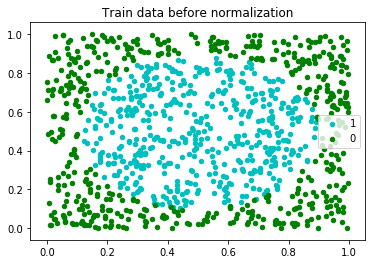

Point outside:  507
Point inside:   493


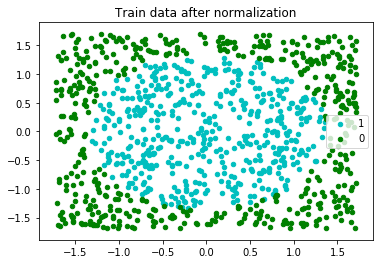

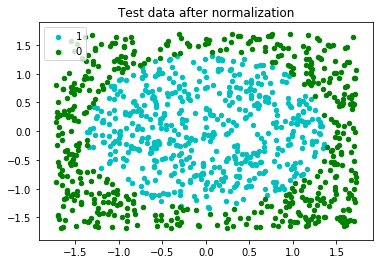

In [10]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)

plot_disc(train_input, train_target, "Train data before normalization")
    
print("Point outside: ", train_input[(train_target[:,1]==0),0].size(0))
print("Point inside:  ", train_input[(train_target[:,1]==1),0].size(0))

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

# Module

In [12]:
class Module( ):
    def forward( self , *input ):
        raise NotImplementedError

    def backward ( self , *gradwrtoutput ):
        raise NotImplementedError

    def param ( self ) :
        return []

## Non linearity

In [83]:
class Activation(Module):
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []


class Tanh(Activation):
    def __init__(self):
        Activation.__init__(self)
        
    def forward(self, x):
        self.s = x
        return x.tanh()

    def backward(self, *gradwrtoutput):
        return (1 - (self.s.tanh()).pow(2)) * (gradwrtoutput[0])
        
    def param(self):
        return []
    
    
class Relu(Activation):
    def __init__(self):
        Activation.__init__(self)
    
    def forward(self, x):
        self.s = x
        
        y = empty(self.s.size()).zero_()
        y[x>0] = x[x>0]
        
        return y

    def backward(self, *gradwrtoutput):
        y = empty(gradwrtoutput[0].size()).zero_()
        y[self.s > 0] = gradwrtoutput[0][self.s > 0]
        
        return y

    def param(self):
        return []
    

class Sigmoid(Activation):
    def __init__(self, p_lambda):
        Activation.__init__(self)
        self.p_lambda = p_lambda
    
    def forward(self, x):
        self.s = x
        return 1/(1 + (-self.p_lambda*x).exp())

    def backward(self, *gradwrtoutput):
        
        return

    def param(self):        
        return []

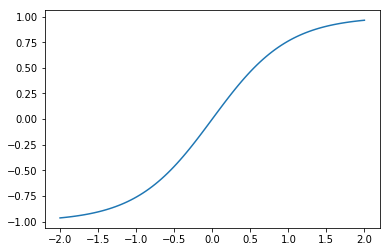

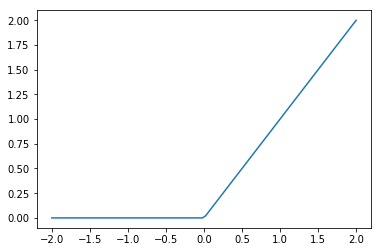

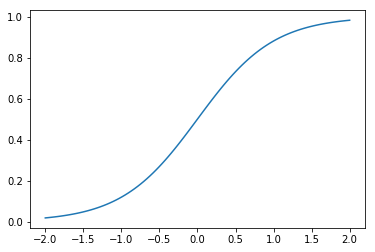

In [85]:
x = torch.linspace(-2,2,100)


tanh_1 = Tanh()
y_tan = tanh_1.forward(x)
plt.plot(x.numpy(), y_tan.numpy())
plt.show()
a = tanh_1.backward(x)

relu_1 = Relu()
y_relu = relu_1.forward(x)
grad = relu_1.backward(y_relu)                       
plt.plot(x.numpy(), y_relu.numpy())
plt.show()

sigmoid_1 = Sigmoid(2)
y_sigmoid = sigmoid_1.forward(x)
grad = sigmoid_1.backward(y_sigmoid)                       
plt.plot(x.numpy(), y_sigmoid.numpy())
plt.show()


## Loss

In [45]:
class Loss(Module):
    
    def __init(self):
        output = empty((0,0))
        target_output = empty((0,0))
    
class LossMSE(Loss):
        
    def forward( self , output, target_output ):
        self.output = output
        self.target_output = target_output
        loss = (output - target_output).pow(2).mean()  # (dim=0).sum()
        return loss
        #raise NotImplementedError

    def backward ( self ):
        return 2*(self.output - self.target_output)/self.output.numel()  # size(dim=0)

    def param ( self ) :
        return []

In [46]:
A = torch.tensor([[1.,1], [2,2]])
B = torch.zeros((2,2))

print((A - B).pow(2))
print((A - B).pow(2).mean(dim=0))
print((A - B).pow(2).mean(dim=0).sum())

print(A.size(dim=0))

tensor([[1., 1.],
        [4., 4.]])
tensor([2.5000, 2.5000])
tensor(5.)
2


## Linear

In [47]:
class Linear(Module): 
    
    def __init__(self, weight_size, bias_size):
        self.bias = empty(bias_size)
        self.weight = empty(weight_size)
        x = empty((0,0))
        s = empty((0,0))
        gradwrtbias = empty((0,0))
        gradwrtweight = empty((0,0))
        
    def normalize_parameters(self, mean, std):
        self.bias = self.bias.normal_(mean=mean, std=std)
        self.weight = self.weight.normal_(mean=mean, std=std)
        
    def define_parameters(self, weight, bias):
        self.weight = weight
        self.bias = bias.view((1, bias.numel()))
        
    
    def forward( self , *input ):
        x = input[0]
        self.x = x
        self.s = torch.mm(x, self.weight.t()) + self.bias
        return self.s

    def backward( self , *gradwrtoutput ):
        gradwrtoutput = gradwrtoutput[0]
        self.gradwrtbias = torch.mm(torch.ones((1, self.x.size(dim=0))) ,gradwrtoutput)
        self.gradwrtweight = torch.mm(gradwrtoutput.t(), self.x)
        return torch.mm(gradwrtoutput, self.weight)
        
    def update_parameters(self, eta):
        self.bias -= eta * self.gradwrtbias
        self.weight -= eta * self.gradwrtweight
        
    def param ( self ) :
        return [self.bias, self.weight]

In [48]:
A = torch.tensor([1.,2])
print(A.size())

torch.Size([2])


# Sequential

torch.Size([2])


## Compute number error

In [49]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

In [50]:
A = torch.tensor([[1,2],[3,2],[10,0]])
B = torch.tensor([1,1,1])

print((A.argmax(dim=1) != B).sum())

tensor(2)


# Test 

In [51]:
# Model definition:
hidden_nb = 25

linear_1 = Linear(weight_size=(hidden_nb, 2) , bias_size=(1,hidden_nb))
relu_1 = Relu()
linear_2 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_2 = Relu()
linear_3 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_3 = Relu()
linear_4 = Linear(weight_size=(2, hidden_nb) , bias_size=(1,2))
loss = LossMSE()


## MODEL BACKWARD PASS
def model_forward(x, target_x):
    x = relu_1.forward(linear_1.forward(x))
    x = relu_2.forward(linear_2.forward(x))
    x = relu_3.forward(linear_3.forward(x))
    x = linear_4.forward(x)    
    #print(x[0:4,:])
    l = loss.forward(x, target_x)
    return (x, l)  
    


## MODEL BACKWARD PASS
passes = [loss, linear_4, relu_3, linear_3, relu_2, linear_2, relu_1, linear_1]

def model_backward(passes, eta):
    grad = passes[0].backward()
    for i in range(1, len(passes)):
        grad = passes[i].backward(grad)
        if passes[i].param():    #If we have parameters
            passes[i].update_parameters(eta)
            
    
    return(grad)
    



In [52]:
#Model iteration
std = 0.1
linear_1.normalize_parameters(mean=0, std=std)
linear_2.normalize_parameters(mean=0, std=std)
linear_3.normalize_parameters(mean=0, std=std)
linear_4.normalize_parameters(mean=0, std=std)
eta = 3e-3
batch_size = 200
epochs_number = 1000

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        _, loss_value = model_forward(train_input.narrow(0, b, batch_size), train_target.narrow(0, b, batch_size)) #.narrow(0, b, batch_size)
        model_backward(passes, eta)
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
        #eta = eta*0.95
    
        




0 :  0.5361588001251221
50 :  0.2924385666847229
100 :  0.2550717294216156
150 :  0.250034362077713
200 :  0.24932941794395447
250 :  0.24915558099746704
300 :  0.24904045462608337
350 :  0.2489381581544876
400 :  0.24884244799613953
450 :  0.24874800443649292
500 :  0.24865050613880157
550 :  0.24854955077171326
600 :  0.2484450787305832
650 :  0.24833741784095764
700 :  0.24822530150413513
750 :  0.24810783565044403
800 :  0.2479850798845291
850 :  0.24785402417182922
900 :  0.2477141171693802
950 :  0.24756337702274323


In [53]:
# Test set: 

output, l = model_forward(test_input, test_target)

print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target))

print(output[0:10,:])
print(test_target[0:10,:])

Loss:  0.2478724867105484
Number of errors:  tensor(504)
tensor([[0.4998, 0.4919],
        [0.5088, 0.4971],
        [0.5054, 0.4929],
        [0.5273, 0.4998],
        [0.5086, 0.4934],
        [0.5190, 0.5010],
        [0.5235, 0.4972],
        [0.5020, 0.4923],
        [0.4981, 0.4961],
        [0.4982, 0.4943]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])


In [54]:
print(linear_4.gradwrtweight[:,0:4])
print(linear_3.gradwrtweight[0:4,0:4])
print(linear_2.gradwrtweight[0:4,0:4])
print(linear_1.gradwrtweight[0:4,:])

tensor([[ 0.0000,  0.0000, -0.0070,  0.0000],
        [ 0.0000,  0.0000,  0.0070,  0.0000]])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.8258e-05,  4.6856e-05,  2.6172e-05,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[ 8.3494e-05,  5.6715e-06,  3.1680e-05,  1.5196e-05],
        [ 3.4126e-04,  1.1694e-05,  1.4125e-04,  4.1126e-05],
        [-7.0986e-04, -4.2587e-06, -3.1520e-04, -5.8729e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[ 2.3240e-03,  1.4935e-03],
        [ 8.5772e-06, -6.3879e-04],
        [-4.2453e-04, -1.4199e-04],
        [-4.7917e-04, -4.0273e-04]])


## Comparison Test

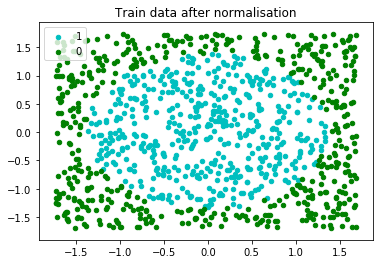

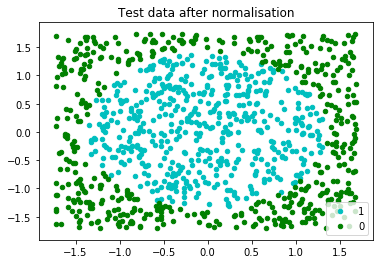

tensor([[-1.5027, -1.6880],
        [ 0.7084,  0.6484],
        [ 1.3876, -1.4982],
        [-0.1979,  0.7328],
        [ 1.4299, -0.8668],
        [ 1.5657,  1.4298],
        [ 0.4573,  0.0289],
        [-1.2358, -0.3872],
        [ 1.0631, -0.1452],
        [ 1.1408, -1.1439]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])


In [55]:
import torch.nn as nn

from torch.autograd import Variable
from torch.nn import functional as F

plt.scatter(train_input[(train_target[:,1]==1),0] ,train_input[(train_target[:,1]==1),1], color = "c", s=20)
plt.scatter(train_input[(train_target[:,1]==0),0] ,train_input[(train_target[:,1]==0),1], color = "g", s=20)
plt.title("Train data after normalisation")
plt.legend(["1", "0"] )
plt.show()

plt.scatter(test_input[(test_target[:,1]==1),0] ,test_input[(test_target[:,1]==1),1], color = "c", s=20)
plt.scatter(test_input[(test_target[:,1]==0),0] ,test_input[(test_target[:,1]==0),1], color = "g", s=20)
plt.title("Test data after normalisation")
plt.legend(["1", "0"] )
plt.show()


print(train_input[0:10,:])
print(train_target[0:10,:])

hidden_nb = 25

### With autograd

In [56]:
torch.set_grad_enabled(True)
train_input = Variable(train_input.data, requires_grad=True)

class Net(nn.Module):
    def __init__(self, hidden_neurons = 25):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc3 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc4 = nn.Linear(hidden_neurons, 2)

    def forward(self, x):
        x_0 = F.relu(self.fc1(x))
        x_1 = F.relu(self.fc2(x_0))
        x_2 = F.relu(self.fc3(x_1))
        x_3 = self.fc4(x_2)
        y = (x_0, x_1, x_2, x_3)
        return y

model, criterion = Net(), nn.MSELoss()

true_output = model(train_input)
true_loss = criterion(true_output[3], train_target)
print("Loss: ", true_loss.item())
#print(true_output[3][0:10,:])

model.zero_grad()
#true_loss.backward()
# print(model.fc1.bias)
print(torch.autograd.grad(true_loss, model.fc3.weight)[0])


torch.set_grad_enabled(False)


Loss:  0.4821913540363312
tensor([[-1.5576e-02, -2.1128e-02, -7.1027e-04, -1.3159e-03,  0.0000e+00,
         -1.2008e-03, -6.8151e-03, -1.7962e-02, -3.2157e-02, -1.8013e-03,
          0.0000e+00, -3.1860e-03, -1.2303e-02, -1.3944e-02, -2.0404e-02,
         -1.5168e-03, -8.8194e-03, -2.6847e-03, -1.7162e-03, -1.4908e-04,
         -1.0164e-03, -1.6089e-02,  0.0000e+00, -6.4382e-03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          

### Without autograd

In [57]:




linear_1 = Linear(weight_size=(hidden_nb, 2) , bias_size=(1,hidden_nb))
relu_1 = Relu()
linear_2 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_2 = Relu()
linear_3 = Linear(weight_size=(hidden_nb,hidden_nb) , bias_size=(1,hidden_nb))
relu_3 = Relu()
linear_4 = Linear(weight_size=(2, hidden_nb) , bias_size=(1,2))
loss = LossMSE()


# linear_1.normalize_parameters(mean=1, std=2)
# linear_2.normalize_parameters(mean=1, std=2)
# linear_3.normalize_parameters(mean=1, std=2)
# linear_4.normalize_parameters(mean=1, std=2)

linear_1.define_parameters(model.fc1.weight, model.fc1.bias)
linear_2.define_parameters(model.fc2.weight, model.fc2.bias)
linear_3.define_parameters(model.fc3.weight, model.fc3.bias)
linear_4.define_parameters(model.fc4.weight, model.fc4.bias)



def model_forward(x, target_x):
    x = relu_1.forward(linear_1.forward(x))
    x = relu_2.forward(linear_2.forward(x))
    x = relu_3.forward(linear_3.forward(x))
    x = linear_4.forward(x)    #relu_4.forward(
    #print(x[0:4,:])
    l = loss.forward(x, target_x)
    print("loss: ", l.item(), "\n")
    return x  
    
our_output = model_forward(train_input, train_target)


## MODEL BACKWARD PASS
def model_backward():
    grad = loss.backward()
    #grad = relu_4.backward(grad)
    grad = linear_4.backward(grad)
    #print(grad.t())
    grad = relu_3.backward(grad)
    grad = linear_3.backward(grad)
    #print(grad.size())
    grad = relu_2.backward(grad)
    grad = linear_2.backward(grad)
    #print(grad.size())
    grad = relu_1.backward(grad)
    grad = linear_1.backward(grad)
    #print(grad.size())
    return(grad)

grad = model_backward()

#print(true_output[3][0:4,:])
print(linear_3.gradwrtweight)

loss:  0.48219141364097595 

tensor([[-1.5576e-02, -2.1128e-02, -7.1027e-04, -1.3159e-03,  0.0000e+00,
         -1.2008e-03, -6.8151e-03, -1.7962e-02, -3.2157e-02, -1.8013e-03,
          0.0000e+00, -3.1860e-03, -1.2303e-02, -1.3944e-02, -2.0404e-02,
         -1.5168e-03, -8.8194e-03, -2.6847e-03, -1.7162e-03, -1.4908e-04,
         -1.0164e-03, -1.6089e-02,  0.0000e+00, -6.4382e-03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
       

In [58]:
print(true_output[3][0:3,:])
print(our_output[0:3,:])

tensor([[ 0.0899, -0.0112],
        [ 0.0568,  0.0173],
        [ 0.0139, -0.0295]], requires_grad=True)
tensor([[ 0.0899, -0.0112],
        [ 0.0568,  0.0173],
        [ 0.0139, -0.0295]])


In [20]:
print(linear_4.weight.size())
print(linear_4.gradwrtweight.size())

torch.Size([2, 25])
torch.Size([2, 25])


In [21]:
print(train_target.size())

torch.Size([1000, 2])
